<a href="https://colab.research.google.com/github/tmj1432/Capstone-Deep-Learning-/blob/main/Capstone_Phase_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Capstone : Phase 1

In this notebook, we will be building our own custom CNN model using a dataset consisting pictures of my own face. This model will be trained on four facial expressions (Angry, Sad, Neutral and Happy). 

---

##Mount Google Drive

In [1]:
 from google.colab import drive
 
 drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


---

##Import Libraries

In [2]:
# pip install keract

In [249]:
import tensorflow as tf
import cv2
import sys
import os
import matplotlib.pyplot as plt
import numpy as np
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

import keras
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras import activations
from keras.models import load_model

from keract import get_activations, display_heatmaps, display_activations

---

###Function to Crop Face

As pictures are taken from my iPhone, it is not grayscaled or cropped at my face. The function below helps to grayscale and crop pictures.

In [4]:
def detectFaceOpenCVHaar(framepath, inHeight=300, inWidth=0):
    frame = cv2.imread(framepath)
    frameOpenCVHaar = frame.copy()
    frameHeight = frameOpenCVHaar.shape[0]
    frameWidth = frameOpenCVHaar.shape[1]
    if not inWidth:
        inWidth = int((frameWidth / frameHeight) * inHeight)

    scaleHeight = frameHeight / inHeight
    scaleWidth = frameWidth / inWidth

    frameOpenCVHaarSmall = cv2.resize(frameOpenCVHaar, (inWidth, inHeight))
    frameGray = cv2.cvtColor(frameOpenCVHaarSmall, cv2.COLOR_BGR2GRAY)

    faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = faceCascade.detectMultiScale(frameGray)
    bboxes = []
    for (x, y, w, h) in faces:
        x1 = x
        y1 = y
        x2 = x + w
        y2 = y + h
        cvRect = [int(x1 * scaleWidth), int(y1 * scaleHeight),
                  int(x2 * scaleWidth), int(y2 * scaleHeight)]
        bboxes.append(cvRect)
        cv2.rectangle(frameOpenCVHaar, (cvRect[0], cvRect[1]), (cvRect[2], cvRect[3]), (0, 255, 0),
                      int(round(frameHeight / 150)), 4)
      
    cropped_image = frameOpenCVHaar[cvRect[1]:cvRect[3], cvRect[0]:cvRect[2]]
    cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
    return cropped_image

In [5]:
def img_show(path):
  cropped = detectFaceOpenCVHaar(path)  
  plt.imshow(cropped, cmap="gray", vmin=0, vmax=255)

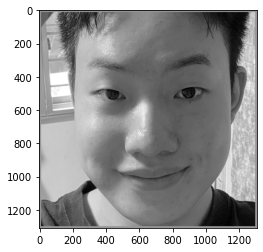

In [6]:
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/happy/IMG_9468.JPG')

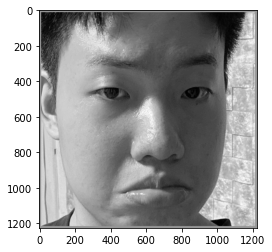

In [7]:
img_show('/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train/sad/IMG_9847.JPG')

We can see that our cropping function is doing well.

---

##Image Pre-processing

In order for our model to interpret images, we have to process them accordingly.

###Create Train Data

In [8]:
def create_image_data(data,img_size, datadirectory, classes):
    for category in classes:
        path = os.path.join(datadirectory, category)
        class_num = classes.index(category)
        for img in os.listdir(path):
            try:
              #function to crop face
                img_array = detectFaceOpenCVHaar(os.path.join(path, img))
                new_array = cv2.resize(img_array, (img_size, img_size))
                data.append([new_array,class_num])
            except Exception as e:
                pass

In [9]:
# read all the images and convert them to array
training_data = [] 

# path
datadirectory_train = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/train' 

# classes
classes = ['angry','happy','neutral','sad']

# using pre-defined function 
create_image_data(training_data, 224, datadirectory_train, classes)

###Train-Validate Split

In [10]:
# shuffle training data 
random.shuffle(training_data)

In [11]:
X = []
y = []

for features, label in training_data:
    X.append(features)
    y.append(label)

In [12]:
# X forms the training images, and y forms the training labels
X = np.array(X)
y = to_categorical(y)

In [13]:
# train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [14]:
# Each image's dimension is 224 x 224
img_rows, img_cols = 224, 224
input_shape = (img_rows, img_cols, 1)

# Prepare the training images
X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
X_train = X_train.astype('float32')
X_train /= 255

# Prepare the validation images
X_val = X_val.reshape(X_val.shape[0], img_rows, img_cols, 1)
X_val = X_val.astype('float32')
X_val /= 255

###Create Test Data

In [15]:
# read all the images and convert them to array
testing_data = [] 

# path
datadirectory_test = '/content/gdrive/MyDrive/Colab Notebooks/Capstone/phase 1/test' 

# using pre-defined function 
create_image_data(testing_data, 224, datadirectory_test, classes)

In [16]:
# shuffle training data 
random.shuffle(testing_data)

In [17]:
X_test = []
y_test = []

for features, label in testing_data:
    X_test.append(features)
    y_test.append(label)

In [18]:
# X forms the testing images, and y forms the testing labels
X_test = np.array(X_test)
y_test = to_categorical(y_test)

In [19]:
# Prepare the training images
X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
X_test = X_test.astype('float32')
X_test /= 255

---

##Modeling

In this section, we will be testing out between two models and two methods.

Model 1: using only 1 layer

Model 2: using 3 layers

Method 1: Without image augmentation

Method 2: With image augmentation

`Image augmentation` is a process of artificially increasing the amount of data by generating new data points from existing data. This includes adding minor alterations to data or using machine learning models to generate new data points in the latent space of original data to amplify the dataset.

###1 Layer

In [212]:
cnn1 = Sequential()
cnn1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn1.add(MaxPooling2D(pool_size=(2, 2)))
cnn1.add(Dropout(0.2))

cnn1.add(Flatten())

cnn1.add(Dense(128, activation='relu'))
cnn1.add(Dense(4, activation='softmax'))

cnn1.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [213]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [214]:
history1 = cnn1.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[callback])

Epoch 1/20
16/16 [==============================] - 1s 29ms/step - loss: 8.1356 - accuracy: 0.2692 - val_loss: 1.9643 - val_accuracy: 0.3203
Epoch 2/20
16/16 [==============================] - 0s 20ms/step - loss: 1.5678 - accuracy: 0.3065 - val_loss: 1.4552 - val_accuracy: 0.3516
Epoch 3/20
16/16 [==============================] - 0s 20ms/step - loss: 1.0970 - accuracy: 0.5187 - val_loss: 1.0152 - val_accuracy: 0.5781
Epoch 4/20
16/16 [==============================] - 0s 18ms/step - loss: 0.7519 - accuracy: 0.7485 - val_loss: 0.9414 - val_accuracy: 0.6328
Epoch 5/20
16/16 [==============================] - 0s 17ms/step - loss: 0.5784 - accuracy: 0.8173 - val_loss: 0.7854 - val_accuracy: 0.6406
Epoch 6/20
16/16 [==============================] - 0s 17ms/step - loss: 0.3509 - accuracy: 0.9273 - val_loss: 0.5777 - val_accuracy: 0.7969
Epoch 7/20
16/16 [==============================] - 0s 20ms/step - loss: 0.1987 - accuracy: 0.9921 - val_loss: 0.4943 - val_accuracy: 0.8594
Epoch 8/20
16

### Training Results

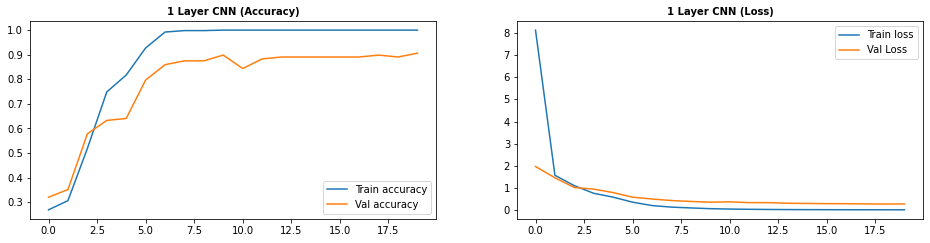

In [215]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'], label='Train accuracy')
plt.plot(history1.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('1 Layer CNN (Accuracy)', fontweight='bold', fontsize=10)

plt.subplot(2,2,2)
plt.plot(history1.history['loss'], label='Train loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('1 Layer CNN (Loss)', fontweight='bold', fontsize=10);

In [216]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.09717857837677
Test accuracy: 0.7340425252914429


From this, we can see that the test accuracy of this model is about 73% which is quite decent.

In [218]:
cnn1.save('cnn1_phase1_pure')

###Image Augmentation

In [219]:
gen = ImageDataGenerator(rotation_range=20, width_shift_range=0.2, shear_range=0.15,
                               height_shift_range=0.2, zoom_range=0.15)
batches = gen.flow(X_train, y_train, batch_size=32)
val_batches = gen.flow(X_val, y_val, batch_size=32)

In [220]:
history1 = cnn1.fit_generator(batches, epochs=20,
                    validation_data=val_batches, validation_steps=len(X_train)//32, use_multiprocessing=True)

<ipython-input-220-f4b17b719207>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history1 = cnn1.fit_generator(batches, epochs=20,


Epoch 1/20
16/16 [==============================] - 9s 529ms/step - loss: 1.9959 - accuracy: 0.2868 - val_loss: 1.4771 - val_accuracy: 0.3500
Epoch 2/20
16/16 [==============================] - 7s 460ms/step - loss: 1.3859 - accuracy: 0.3438 - val_loss: 1.3804 - val_accuracy: 0.3042
Epoch 3/20
16/16 [==============================] - 9s 559ms/step - loss: 1.3669 - accuracy: 0.3045 - val_loss: 1.3562 - val_accuracy: 0.3229
Epoch 4/20
16/16 [==============================] - 7s 449ms/step - loss: 1.3385 - accuracy: 0.3536 - val_loss: 1.3380 - val_accuracy: 0.3667
Epoch 5/20
16/16 [==============================] - 14s 898ms/step - loss: 1.3153 - accuracy: 0.3752 - val_loss: 1.3222 - val_accuracy: 0.3292
Epoch 6/20
16/16 [==============================] - 7s 463ms/step - loss: 1.3404 - accuracy: 0.3713 - val_loss: 1.2954 - val_accuracy: 0.4146
Epoch 7/20
16/16 [==============================] - 7s 462ms/step - loss: 1.3079 - accuracy: 0.3674 - val_loss: 1.2713 - val_accuracy: 0.4062
Epoch

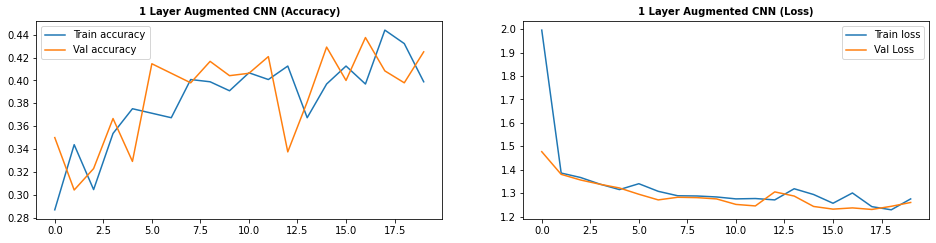

In [221]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(history1.history['accuracy'], label='Train accuracy')
plt.plot(history1.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('1 Layer Augmented CNN (Accuracy)', fontweight='bold', fontsize=10)

plt.subplot(2,2,2)
plt.plot(history1.history['loss'], label='Train loss')
plt.plot(history1.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('1 Layer Augmented CNN (Loss)', fontweight='bold', fontsize=10);

In [222]:
score1 = cnn1.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.5746227502822876
Test accuracy: 0.43617022037506104


In [223]:
cnn1.save('cnn1_phase1_augment')

###3 Layers

In [237]:
cnn3 = Sequential()
cnn3.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
cnn3.add(MaxPooling2D((2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
cnn3.add(MaxPooling2D(pool_size=(2, 2)))
cnn3.add(Dropout(0.25))

cnn3.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
cnn3.add(Dropout(0.4))

cnn3.add(Flatten())

cnn3.add(Dense(128, activation='relu'))
cnn3.add(Dropout(0.3))
cnn3.add(Dense(4, activation='softmax'))

cnn3.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(learning_rate=1e-3),
              metrics=['accuracy'])

In [238]:
history3 = cnn3.fit(X_train, y_train,
          batch_size=32,
          epochs=20,
          verbose=1,
          validation_data=(X_val, y_val),
          callbacks=[callback])

Epoch 1/20
16/16 [==============================] - 1s 40ms/step - loss: 2.7443 - accuracy: 0.2593 - val_loss: 1.3754 - val_accuracy: 0.3203
Epoch 2/20
16/16 [==============================] - 0s 29ms/step - loss: 1.3764 - accuracy: 0.3104 - val_loss: 1.3714 - val_accuracy: 0.3203
Epoch 3/20
16/16 [==============================] - 0s 28ms/step - loss: 1.3731 - accuracy: 0.3438 - val_loss: 1.3585 - val_accuracy: 0.3203
Epoch 4/20
16/16 [==============================] - 0s 28ms/step - loss: 1.3414 - accuracy: 0.3340 - val_loss: 1.3101 - val_accuracy: 0.3828
Epoch 5/20
16/16 [==============================] - 0s 29ms/step - loss: 1.2644 - accuracy: 0.4106 - val_loss: 1.2398 - val_accuracy: 0.4609
Epoch 6/20
16/16 [==============================] - 0s 27ms/step - loss: 1.0995 - accuracy: 0.5187 - val_loss: 0.9737 - val_accuracy: 0.5781
Epoch 7/20
16/16 [==============================] - 0s 29ms/step - loss: 0.8496 - accuracy: 0.6424 - val_loss: 0.5886 - val_accuracy: 0.7422
Epoch 8/20
16

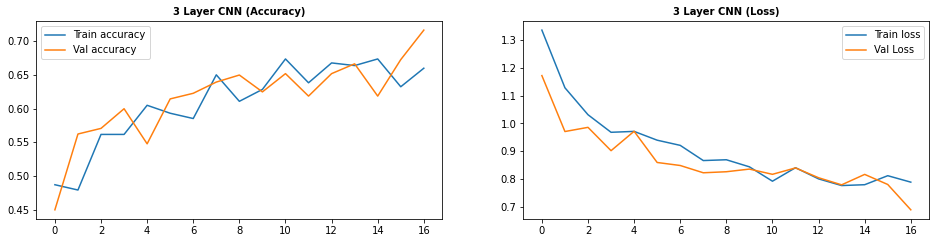

In [245]:
 plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(history3.history['accuracy'], label='Train accuracy')
plt.plot(history3.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('3 Layer CNN (Accuracy)', fontweight='bold', fontsize=10)

plt.subplot(2,2,2)
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('3 Layer CNN (Loss)', fontweight='bold', fontsize=10);

In [240]:
score3 = cnn3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.5746227502822876
Test accuracy: 0.43617022037506104


In [242]:
cnn1.save('cnn3_phase1')

###Image Augmentation

In [243]:
gen = ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=32)
val_batches = gen.flow(X_val, y_val, batch_size=32)

In [244]:
history3 = cnn3.fit_generator(batches, epochs=20,
                    validation_data=val_batches, validation_steps=len(X_train)//32, use_multiprocessing=True,callbacks=[callback])

<ipython-input-244-6d5060924b37>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history3 = cnn3.fit_generator(batches, epochs=20,


Epoch 1/20
16/16 [==============================] - 8s 480ms/step - loss: 1.3366 - accuracy: 0.4872 - val_loss: 1.1726 - val_accuracy: 0.4500
Epoch 2/20
16/16 [==============================] - 7s 472ms/step - loss: 1.1287 - accuracy: 0.4794 - val_loss: 0.9709 - val_accuracy: 0.5625
Epoch 3/20
16/16 [==============================] - 13s 806ms/step - loss: 1.0315 - accuracy: 0.5619 - val_loss: 0.9860 - val_accuracy: 0.5708
Epoch 4/20
16/16 [==============================] - 7s 454ms/step - loss: 0.9682 - accuracy: 0.5619 - val_loss: 0.9019 - val_accuracy: 0.6000
Epoch 5/20
16/16 [==============================] - 7s 450ms/step - loss: 0.9714 - accuracy: 0.6051 - val_loss: 0.9718 - val_accuracy: 0.5479
Epoch 6/20
16/16 [==============================] - 7s 459ms/step - loss: 0.9397 - accuracy: 0.5933 - val_loss: 0.8593 - val_accuracy: 0.6146
Epoch 7/20
16/16 [==============================] - 7s 460ms/step - loss: 0.9211 - accuracy: 0.5855 - val_loss: 0.8485 - val_accuracy: 0.6229
Epoch

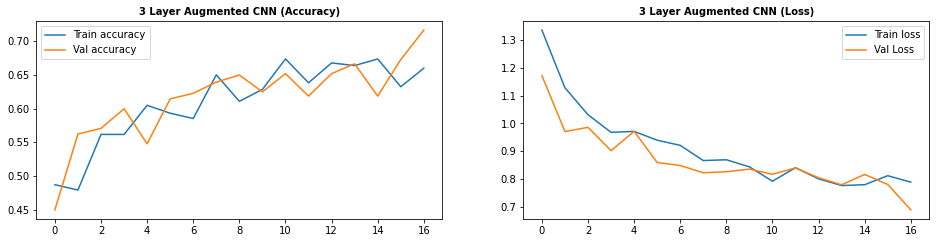

In [246]:
plt.figure(figsize=(16,8))

plt.subplot(2,2,1)
plt.plot(history3.history['accuracy'], label='Train accuracy')
plt.plot(history3.history['val_accuracy'], label='Val accuracy')
plt.legend()
plt.title('3 Layer Augmented CNN (Accuracy)', fontweight='bold', fontsize=10)

plt.subplot(2,2,2)
plt.plot(history3.history['loss'], label='Train loss')
plt.plot(history3.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('3 Layer Augmented CNN (Loss)', fontweight='bold', fontsize=10);

In [247]:
score3 = cnn3.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score1[0])
print('Test accuracy:', score1[1])

Test loss: 1.5746227502822876
Test accuracy: 0.43617022037506104


In [248]:
cnn1.save('cnn3_phase1_augment')

## Evaluate Best Model

|Model|Train Accuracy|Val Accuracy|Test Accuracy|
|---|---|---|---|
|CNN1|1|0.9062|0.7340|
|CNN1 Augmented|0.3988|0.4250|0.4361|
|CNN3|0.9607|0.9219|0.4361|
|CNN3 Augmented|0.6601|0.7167|0.4361|

We can conclude that CNN1 is the best model so far. This proves that simpler model works better for small dataset like the one we are using for this phase.

### Load Best Model

In [250]:
# Input model of your choice
final_model = load_model('/content/gdrive/MyDrive/Colab Notebooks/Capstone/cnn1_phase1_pure')

###Making Predictions

In [251]:
# predict Y using CNN model on test data
y_pred = final_model.predict(X_test)

# display predicted Y-values for first 5 samples
y_pred[:5]

# predicted Y values is a normalised prob distr of values between 0 to 1 as a result of softmax activation function used

3/3 [==============================] - 0s 6ms/step


array([[3.0189429e-03, 3.1741932e-01, 6.0603297e-01, 7.3528782e-02],
       [9.9933273e-01, 3.8557791e-04, 4.8141196e-06, 2.7685502e-04],
       [2.7840291e-03, 1.1598762e-02, 4.4033762e-02, 9.4158340e-01],
       [9.5978670e-04, 7.3467098e-02, 9.1452187e-01, 1.1051282e-02],
       [1.0605157e-01, 8.8791829e-01, 1.3506153e-03, 4.6795490e-03]],
      dtype=float32)

In [252]:
y_test =np.argmax(y_test, axis=1)
# use argmax to retrieve corresponding index for max value of each test sample
y_classes = [np.argmax(element) for element in y_pred]

### Classification Report

In [253]:
print("Classification Report: \n", classification_report(y_test, y_classes))
# Better scores recorded on CNN as seen below as opposed to ANN as seen above

Classification Report: 
               precision    recall  f1-score   support

           0       0.62      1.00      0.76        21
           1       0.94      0.63      0.76        27
           2       0.70      0.67      0.68        24
           3       0.79      0.68      0.73        22

    accuracy                           0.73        94
   macro avg       0.76      0.74      0.73        94
weighted avg       0.77      0.73      0.73        94



Let us look at the f1-score of the classification report. We see that the model is a little lacking in predicting neutral faces. However, for the rest of the emotions, the f1-score are above 73 which is actually pretty decent.

In [254]:
wrong_classified = np.nonzero(y_classes != y_test)[0]
correct_classified = np.nonzero(y_classes==y_test)[0]

### Correctly Classified Images

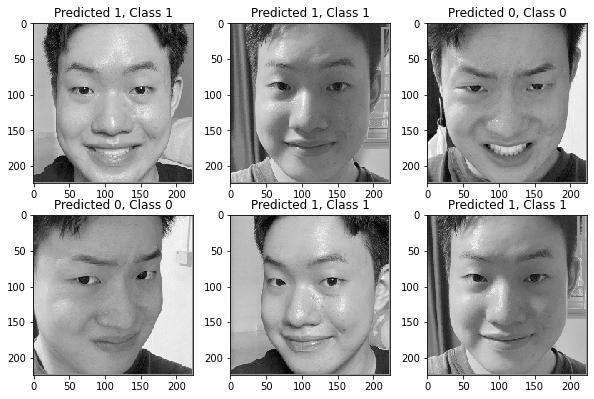

In [281]:
plt.figure(figsize=(10,10))
for i, correct in enumerate(correct_classified[42:48]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[correct].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_classes[correct], y_test[correct]))

### Wrongly Classified Images

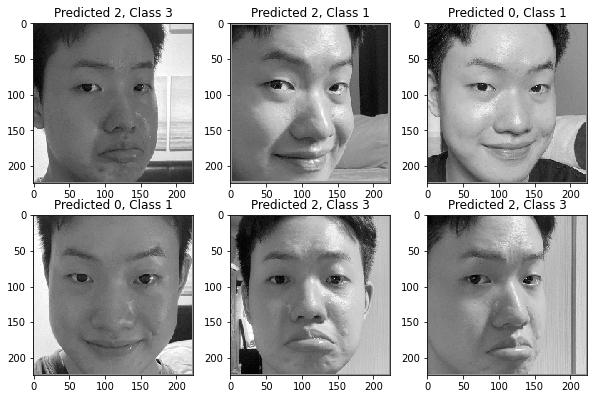

In [280]:
plt.figure(figsize=(10,10))
for i, incorrect in enumerate(wrong_classified[10:16]):
    plt.subplot(3,3,i+1)
    plt.imshow(X_test[incorrect].reshape(224,224), cmap='gray', interpolation='none')
    plt.title("Predicted {}, Class {}".format(y_classes[incorrect], y_test[incorrect]))

###Activations

conv2d_57_input (1, 224, 224, 1) 


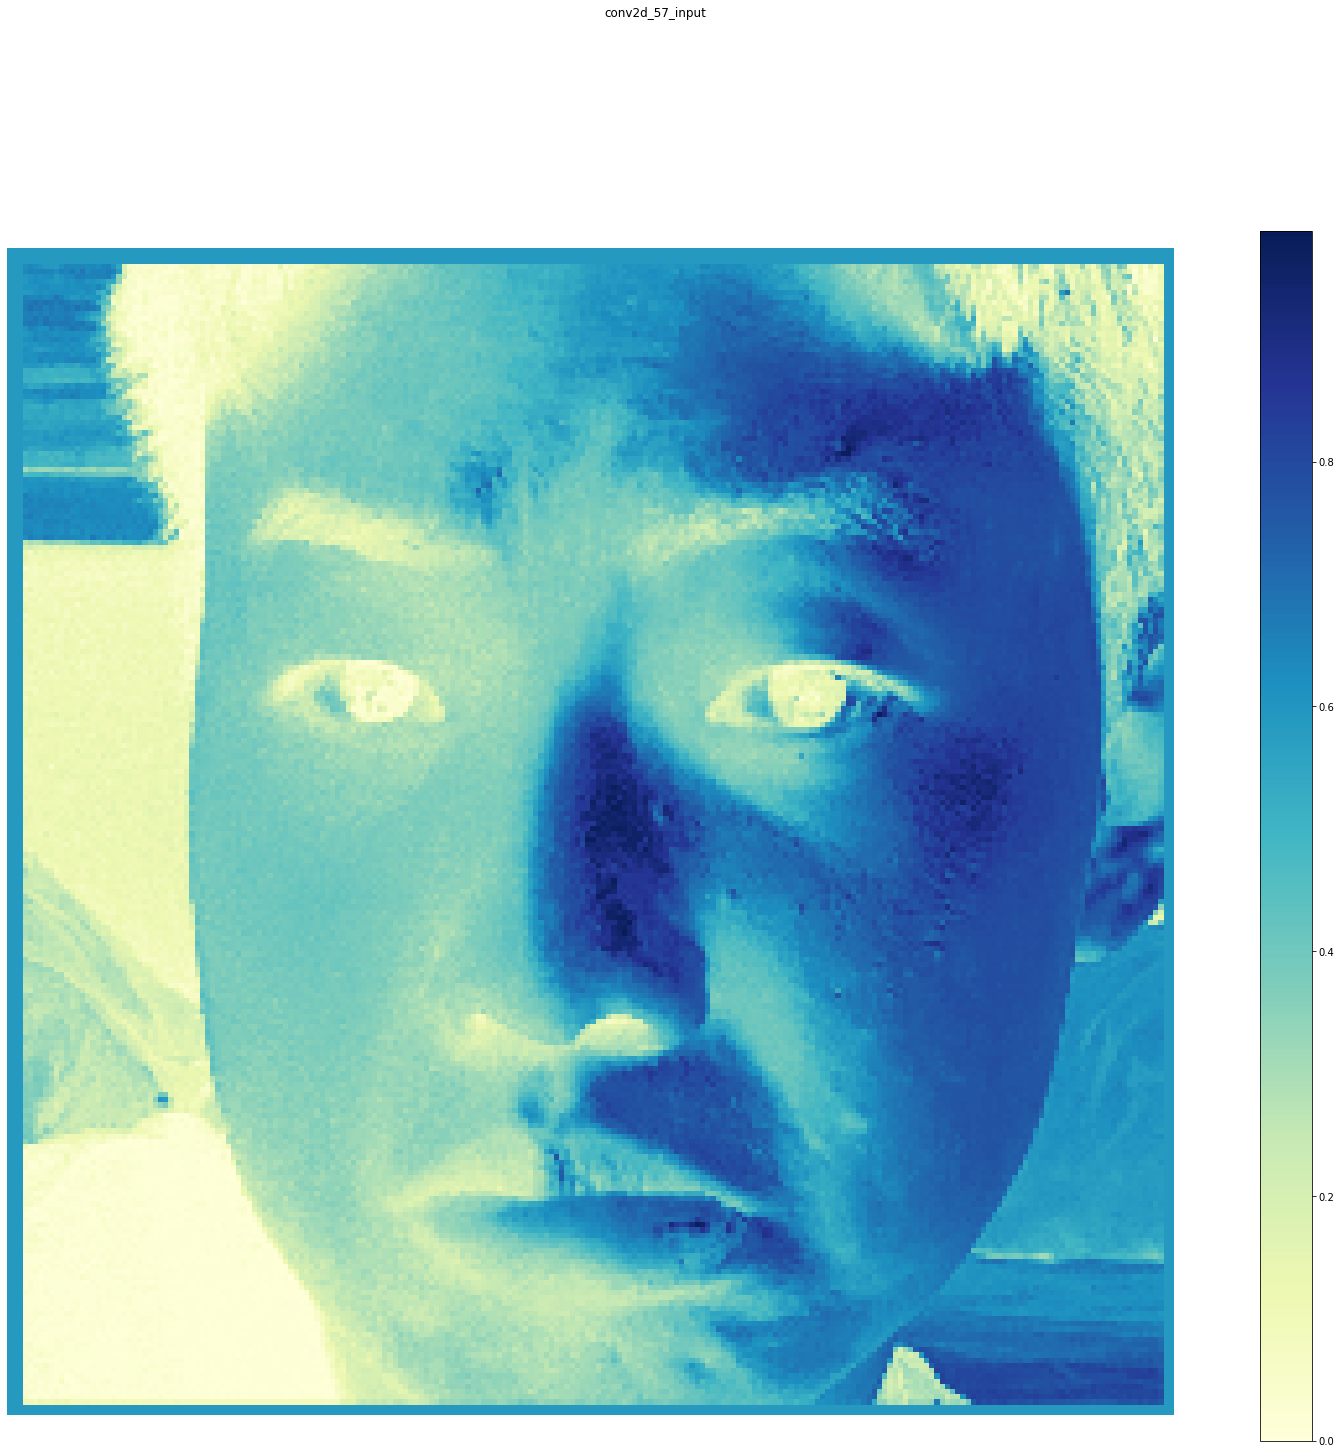

conv2d_57 (1, 222, 222, 32) 


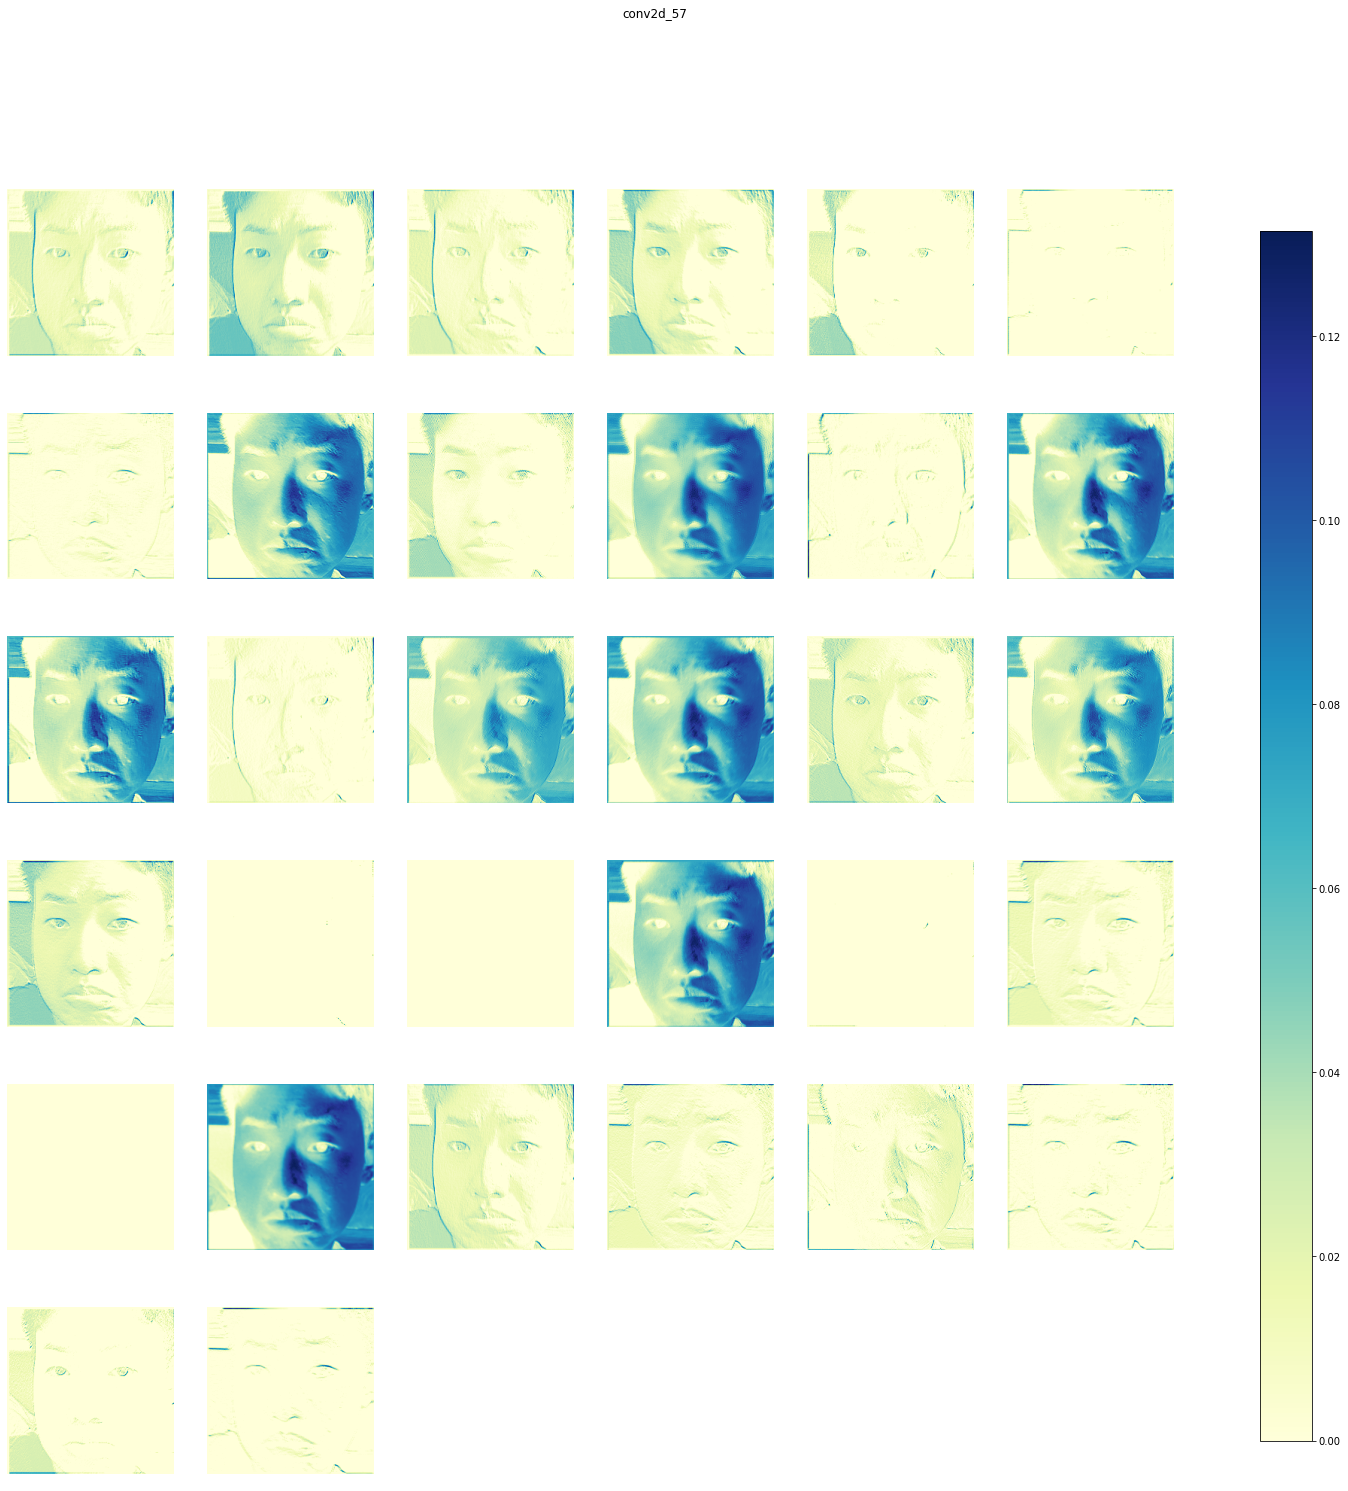

max_pooling2d_46 (1, 111, 111, 32) 


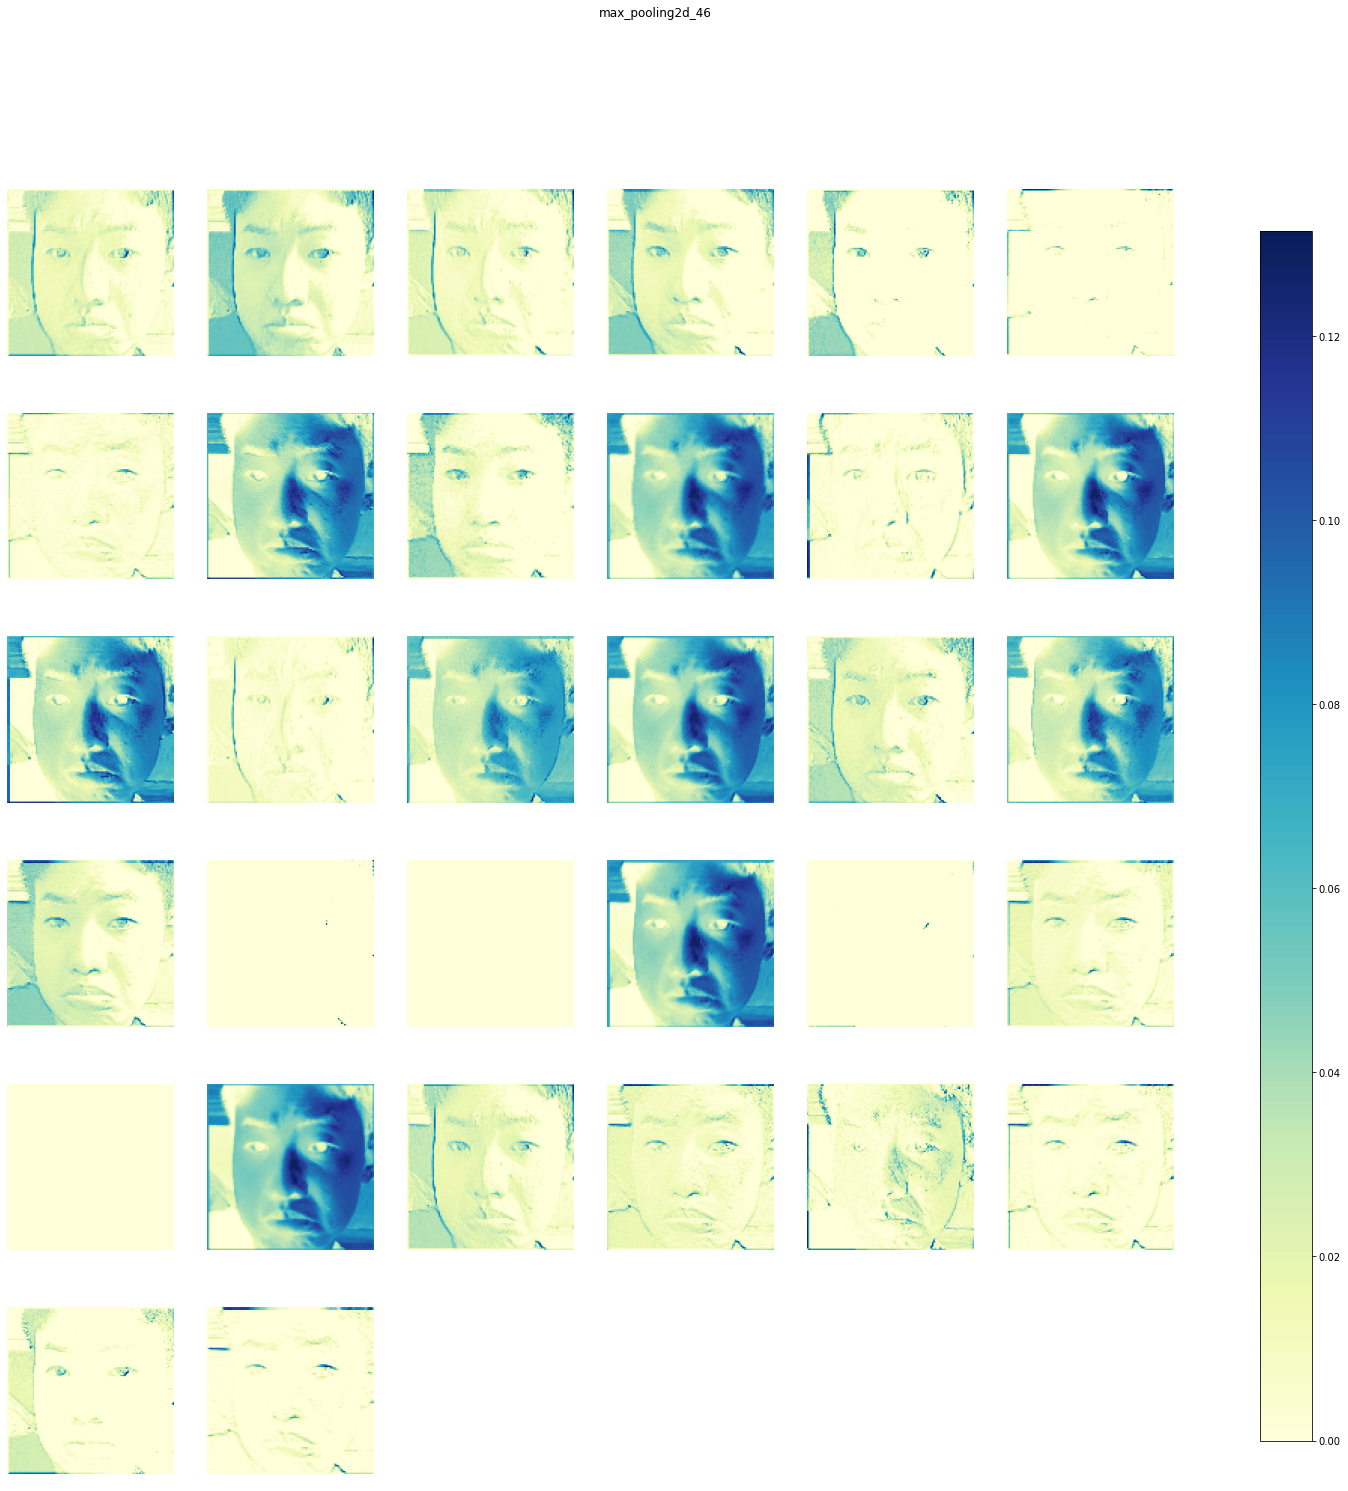

dropout_69 (1, 111, 111, 32) 


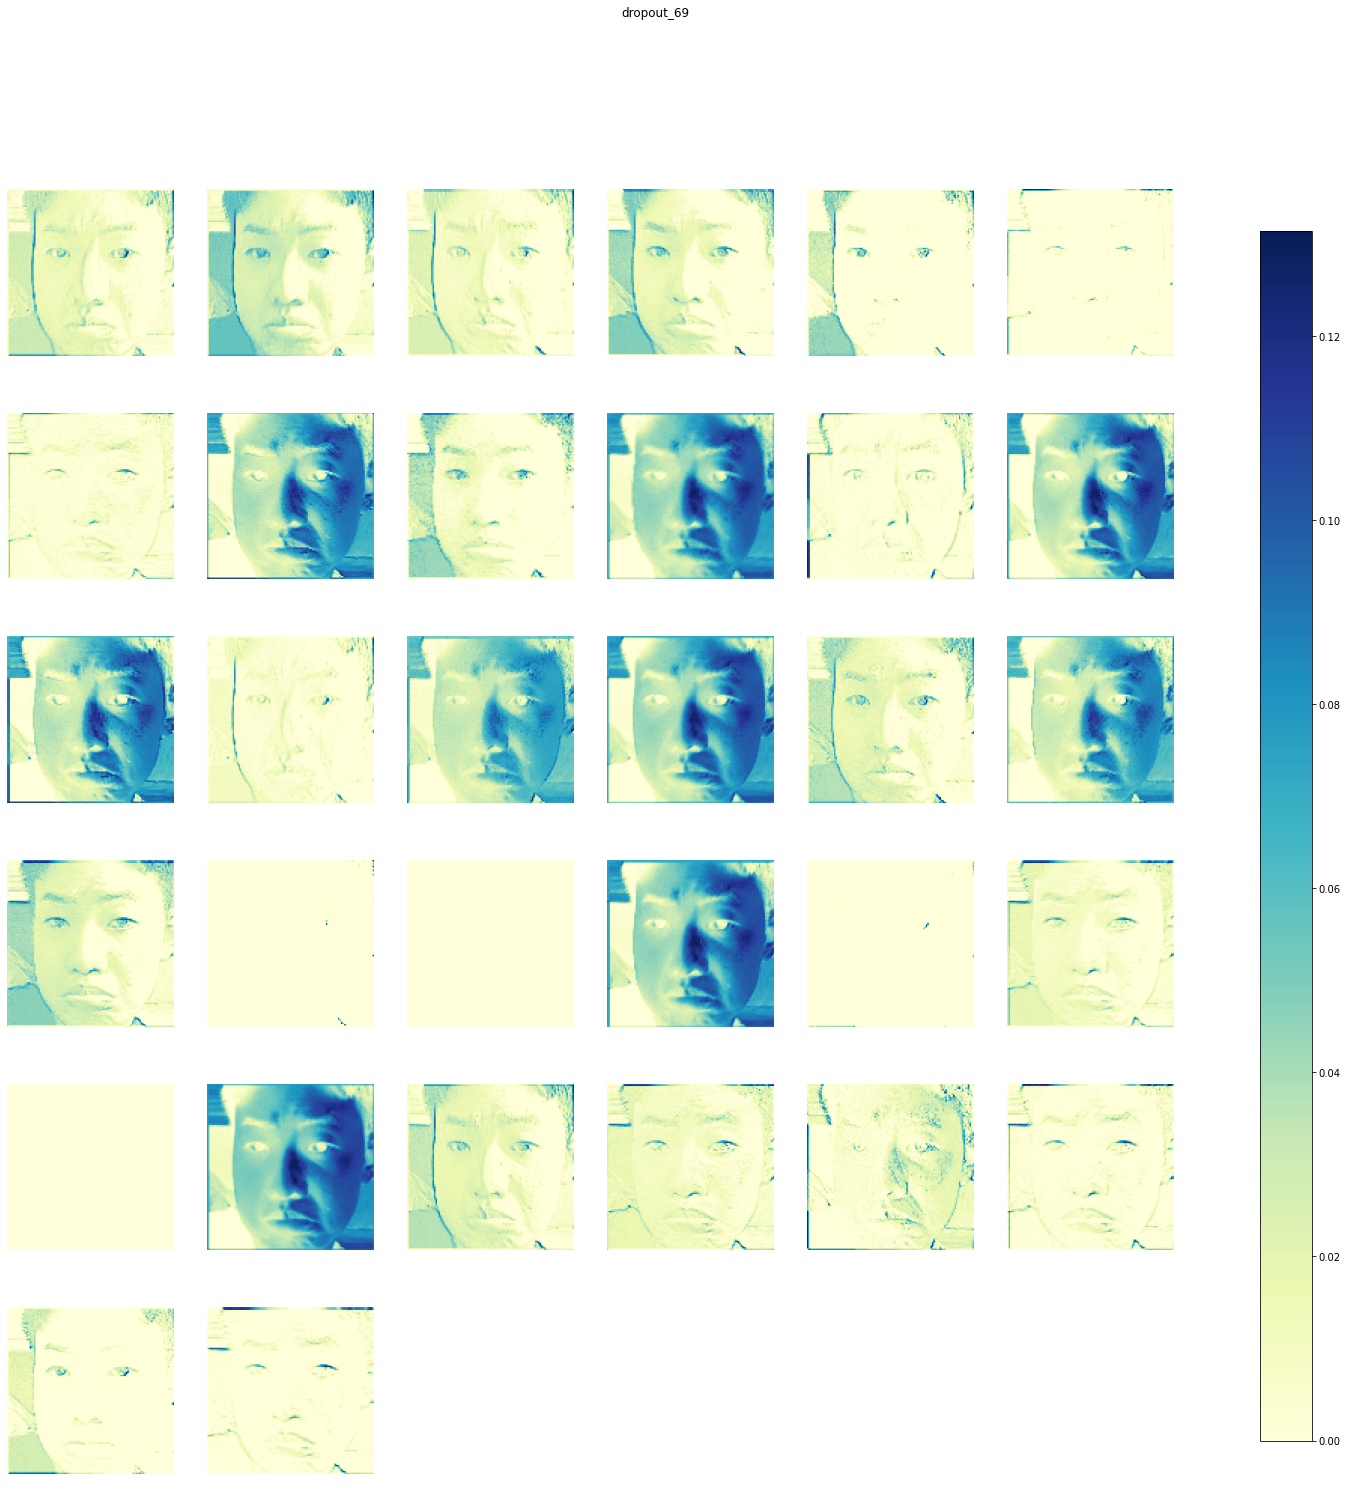

conv2d_58 (1, 109, 109, 64) 


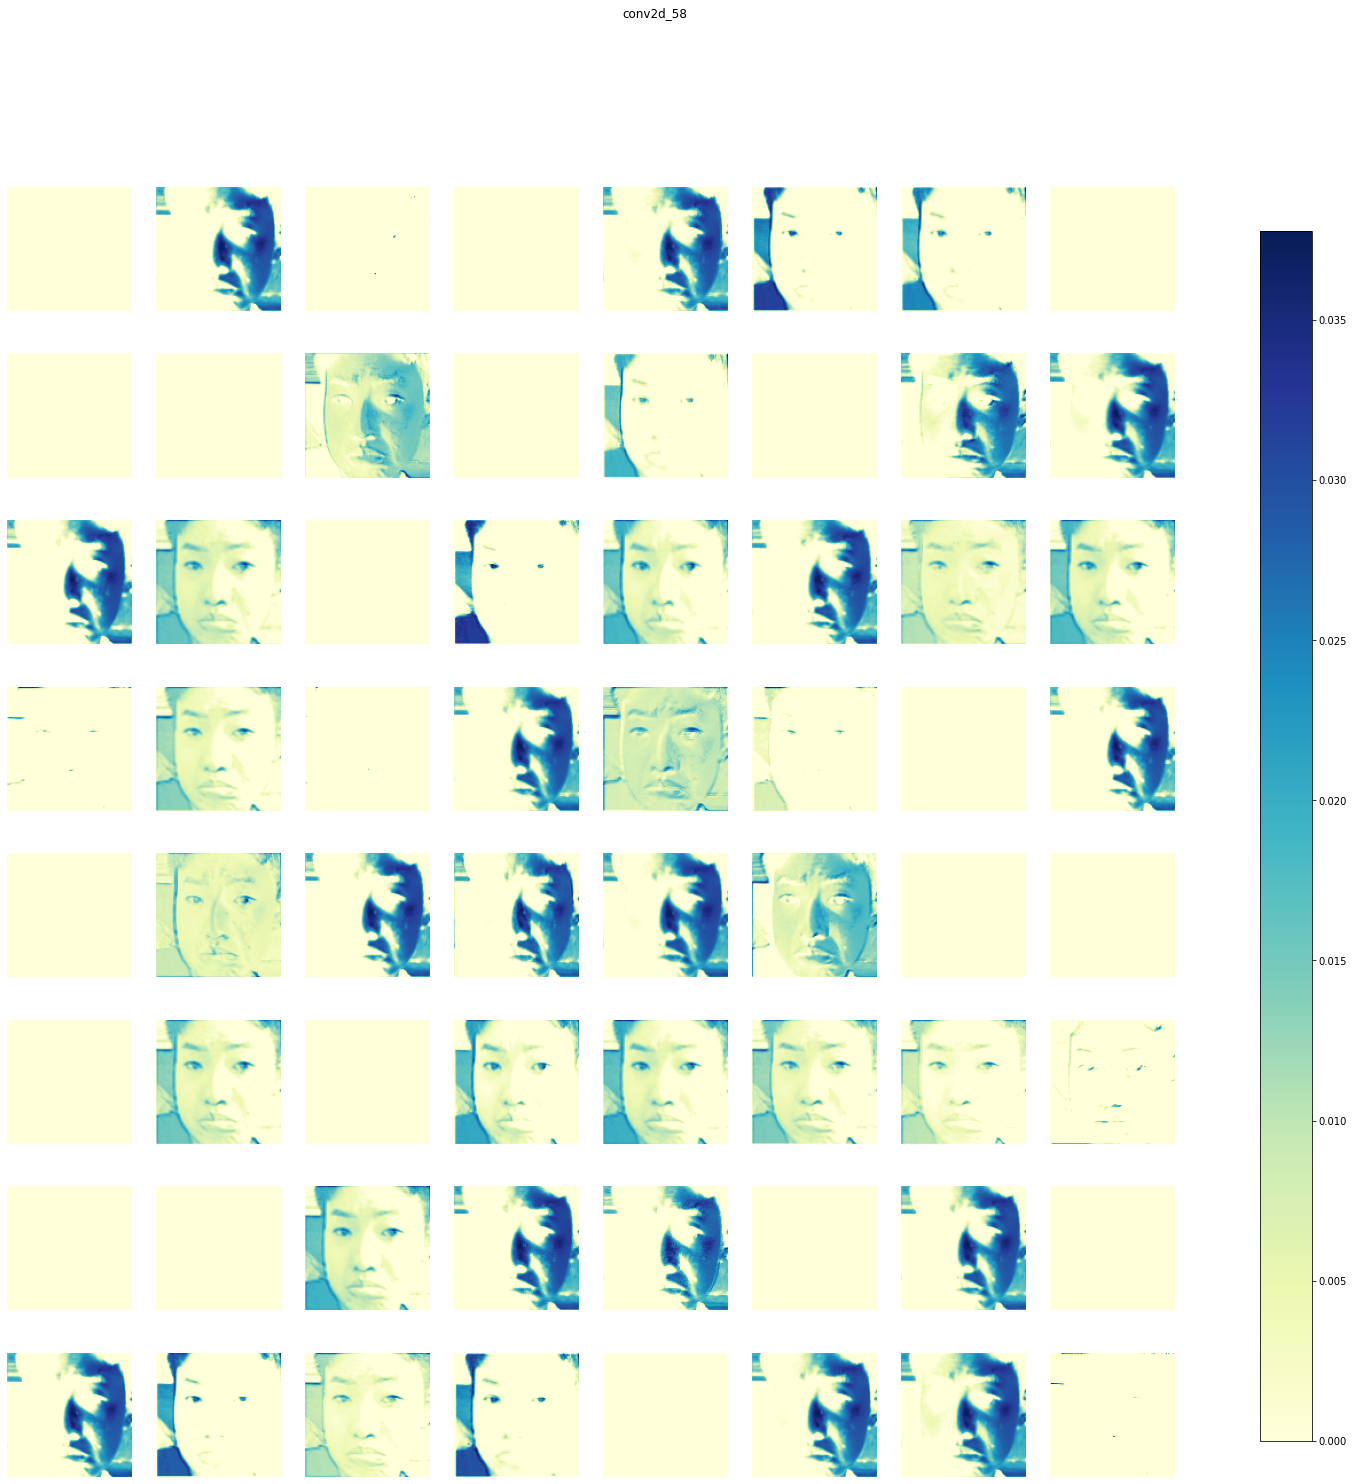

max_pooling2d_47 (1, 54, 54, 64) 


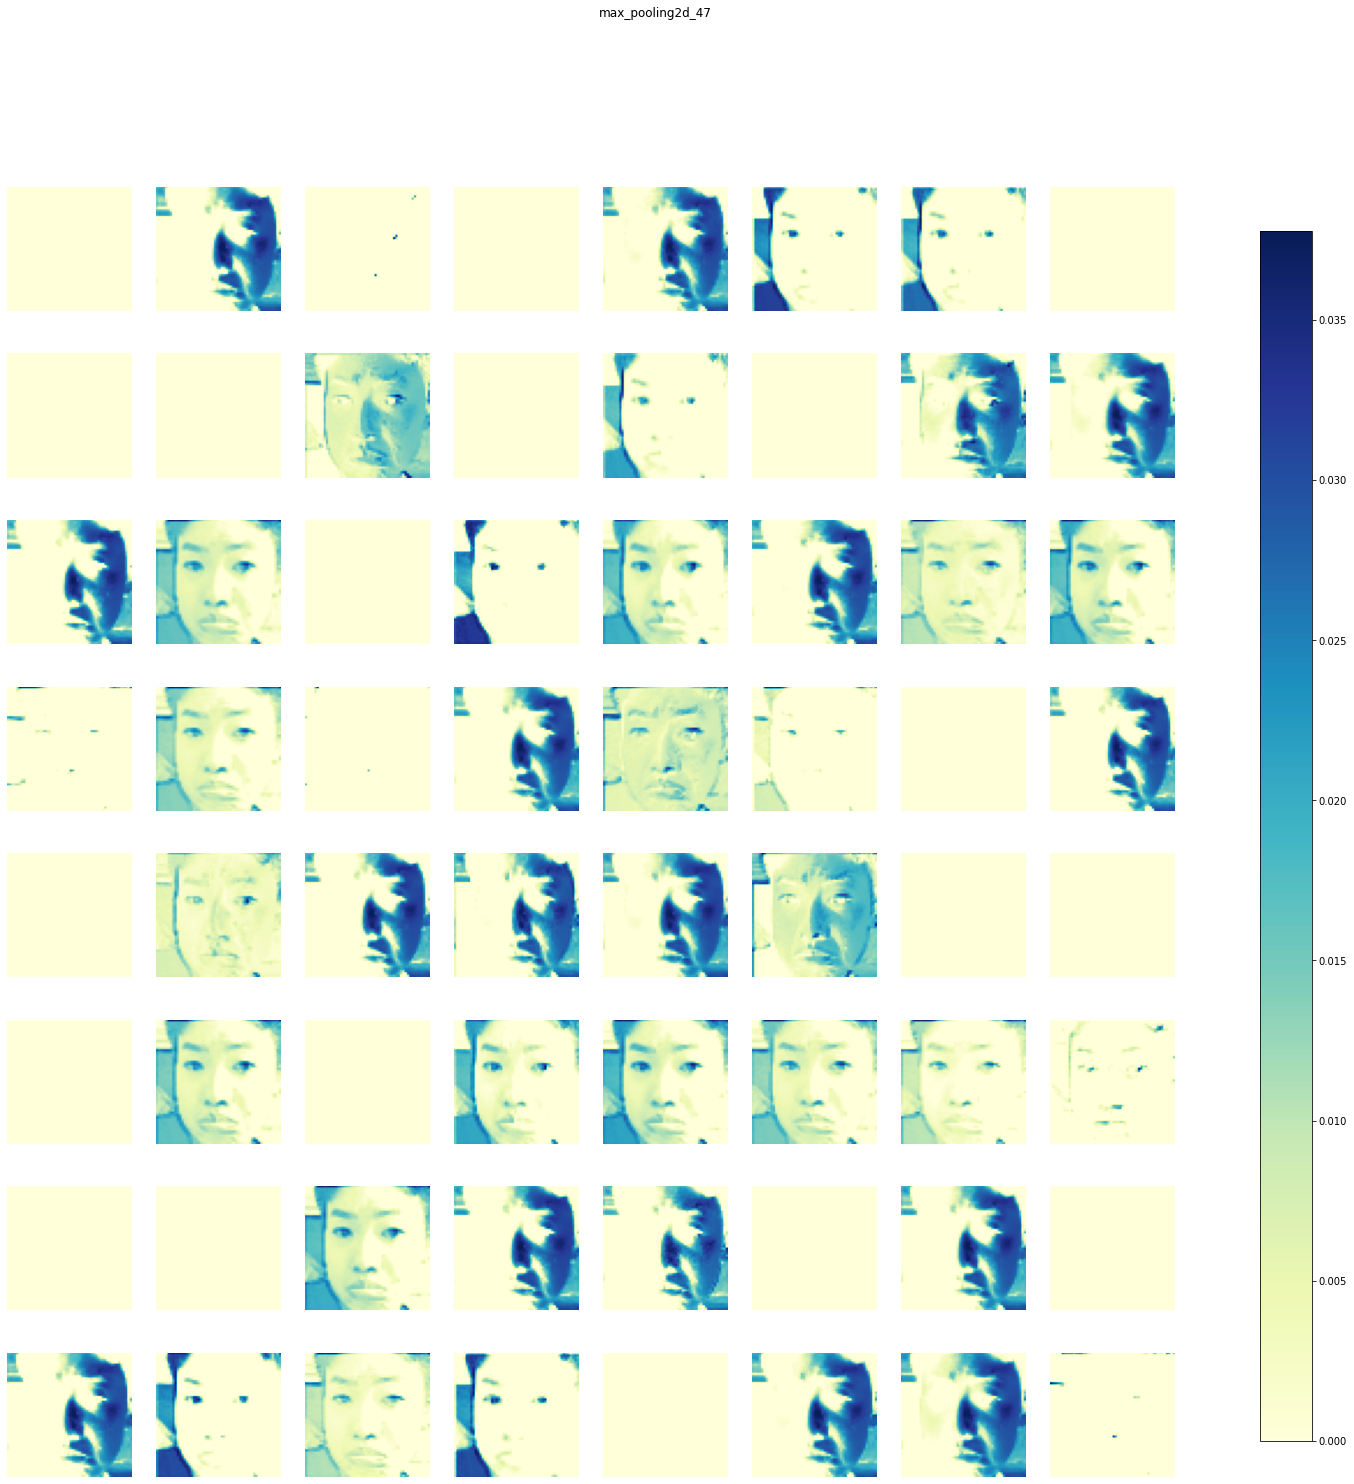

dropout_70 (1, 54, 54, 64) 


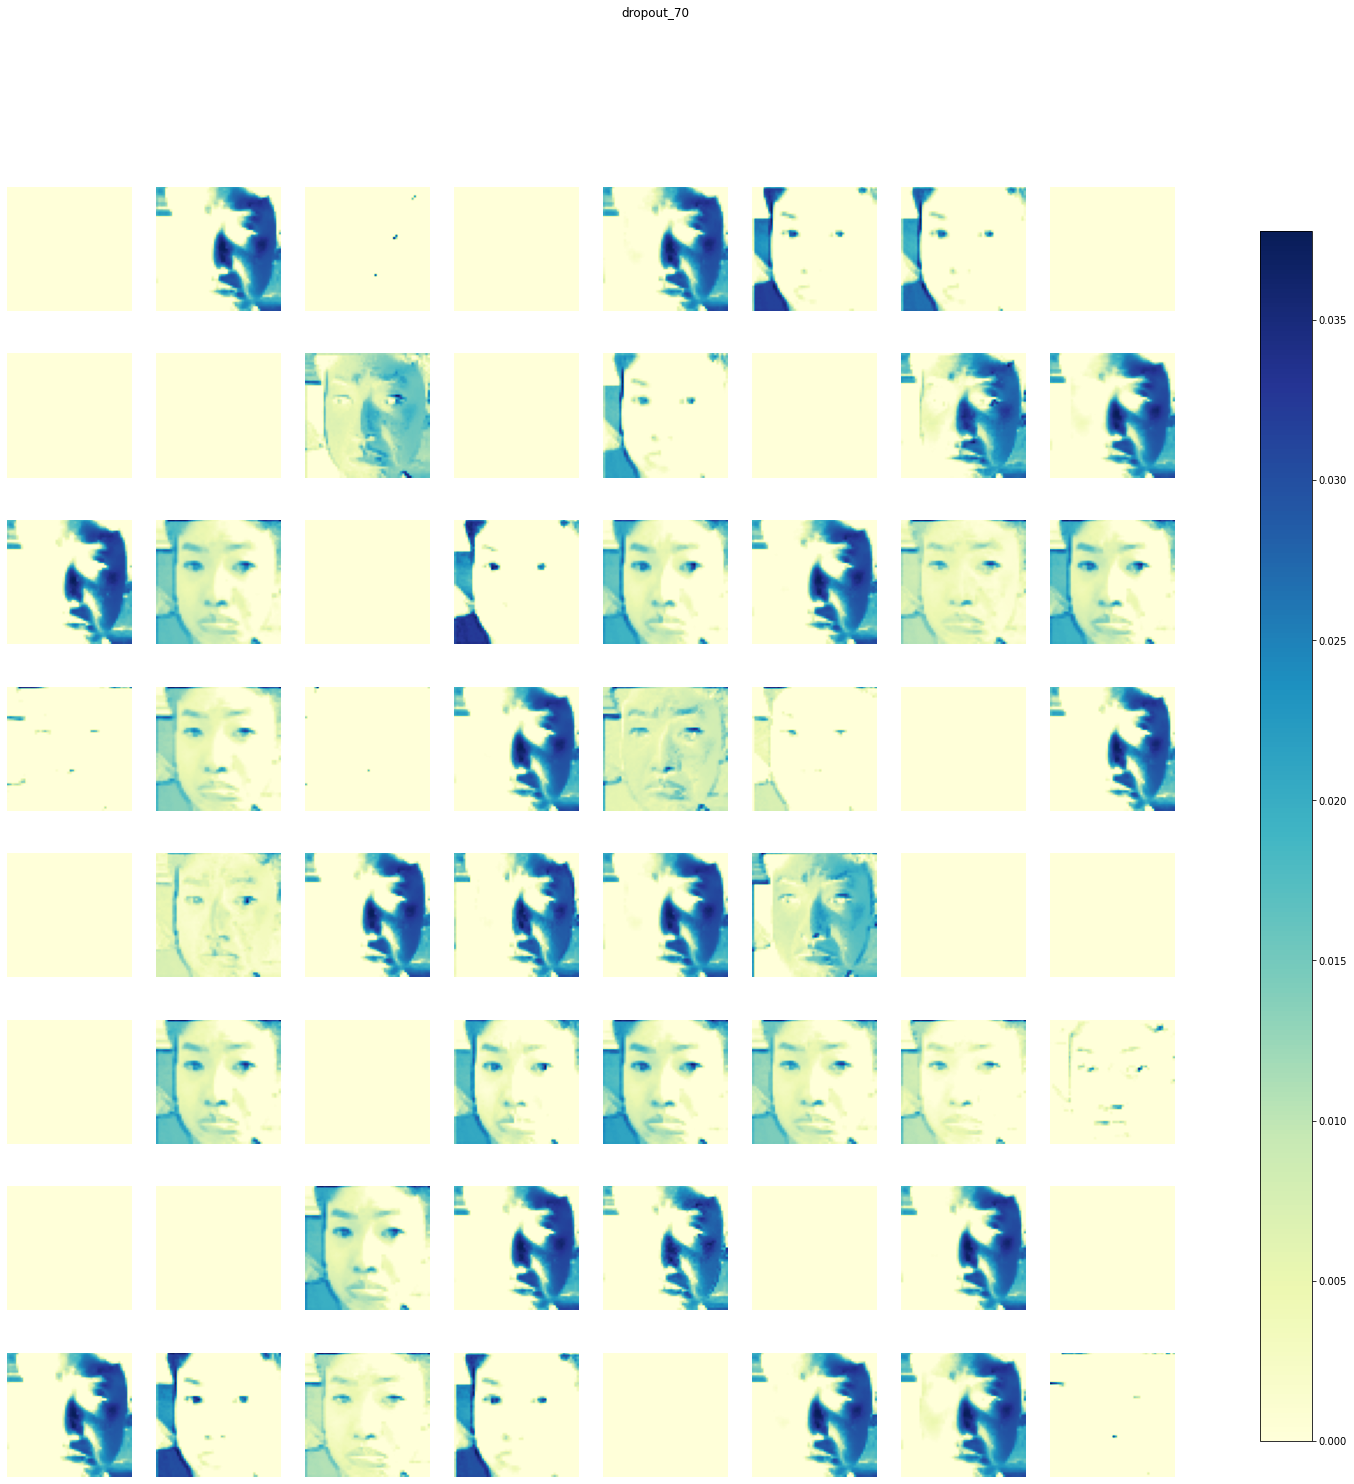

conv2d_59 (1, 52, 52, 128) 


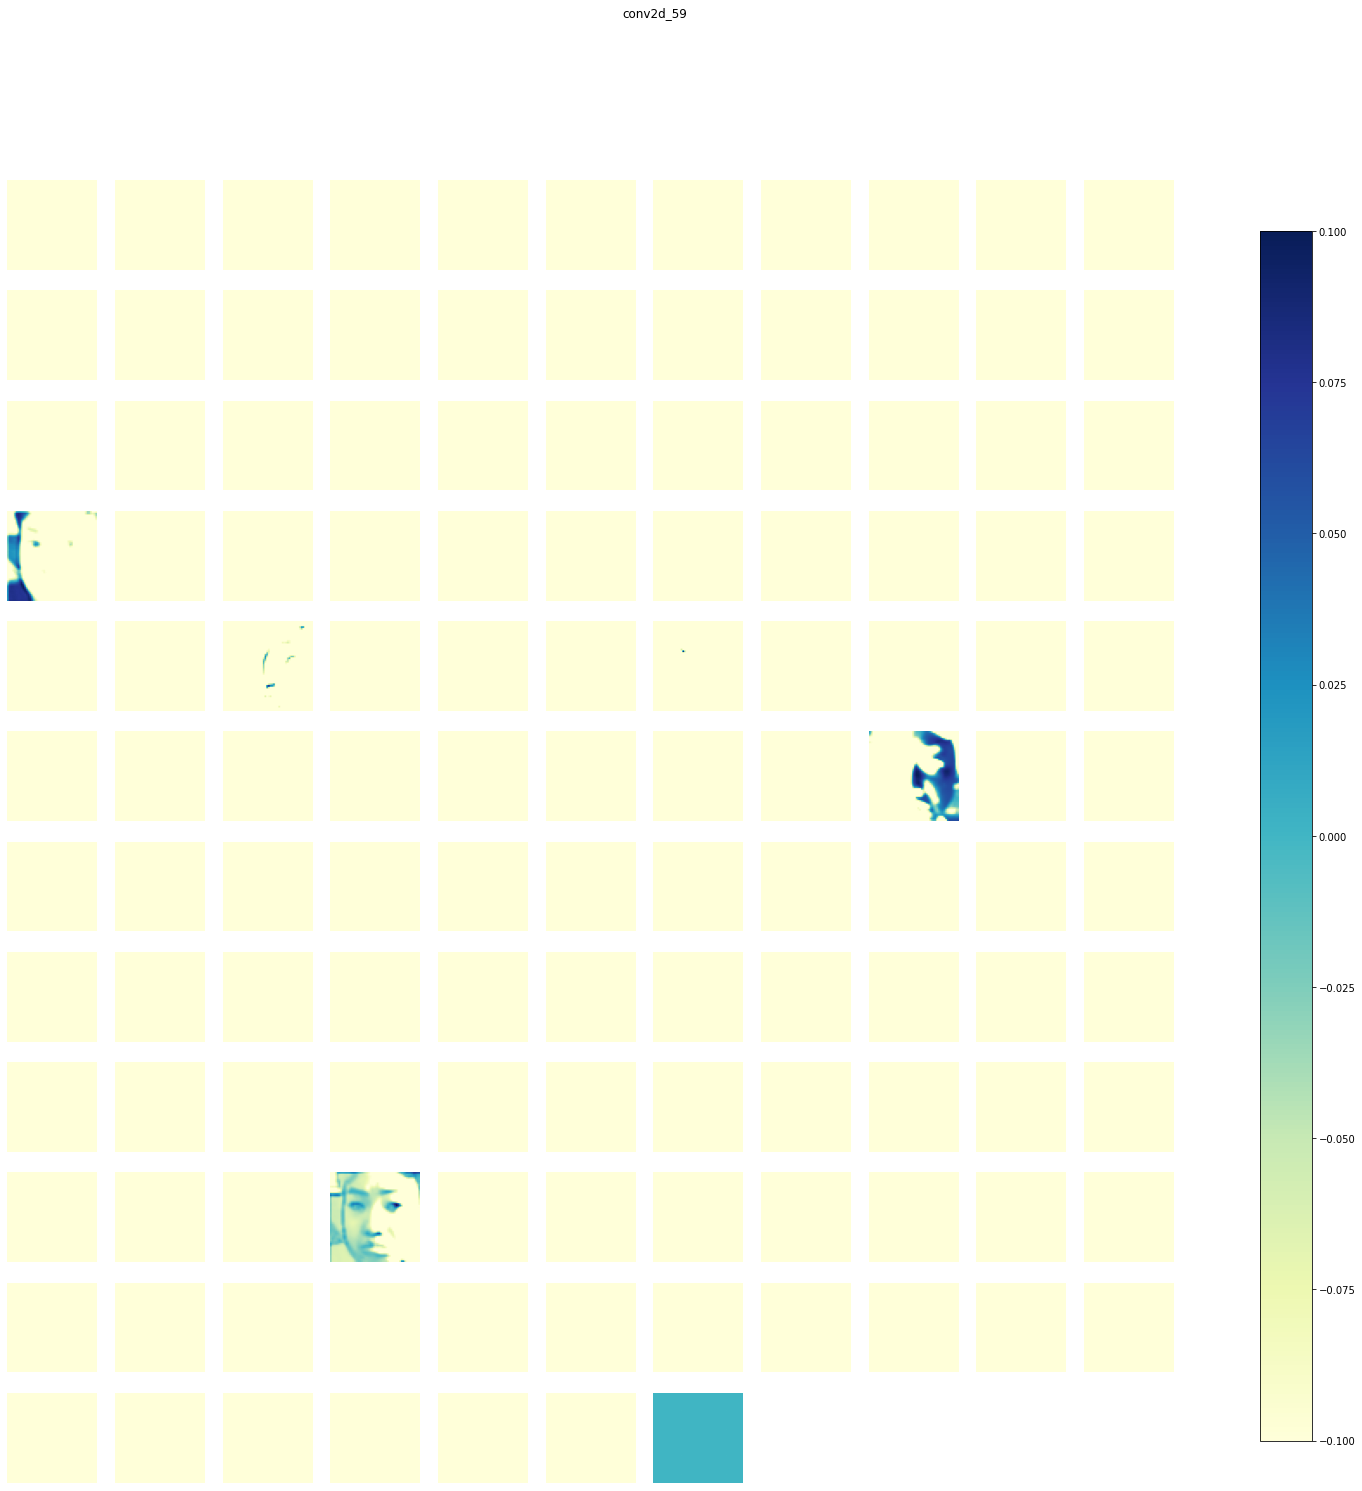

dropout_71 (1, 52, 52, 128) 


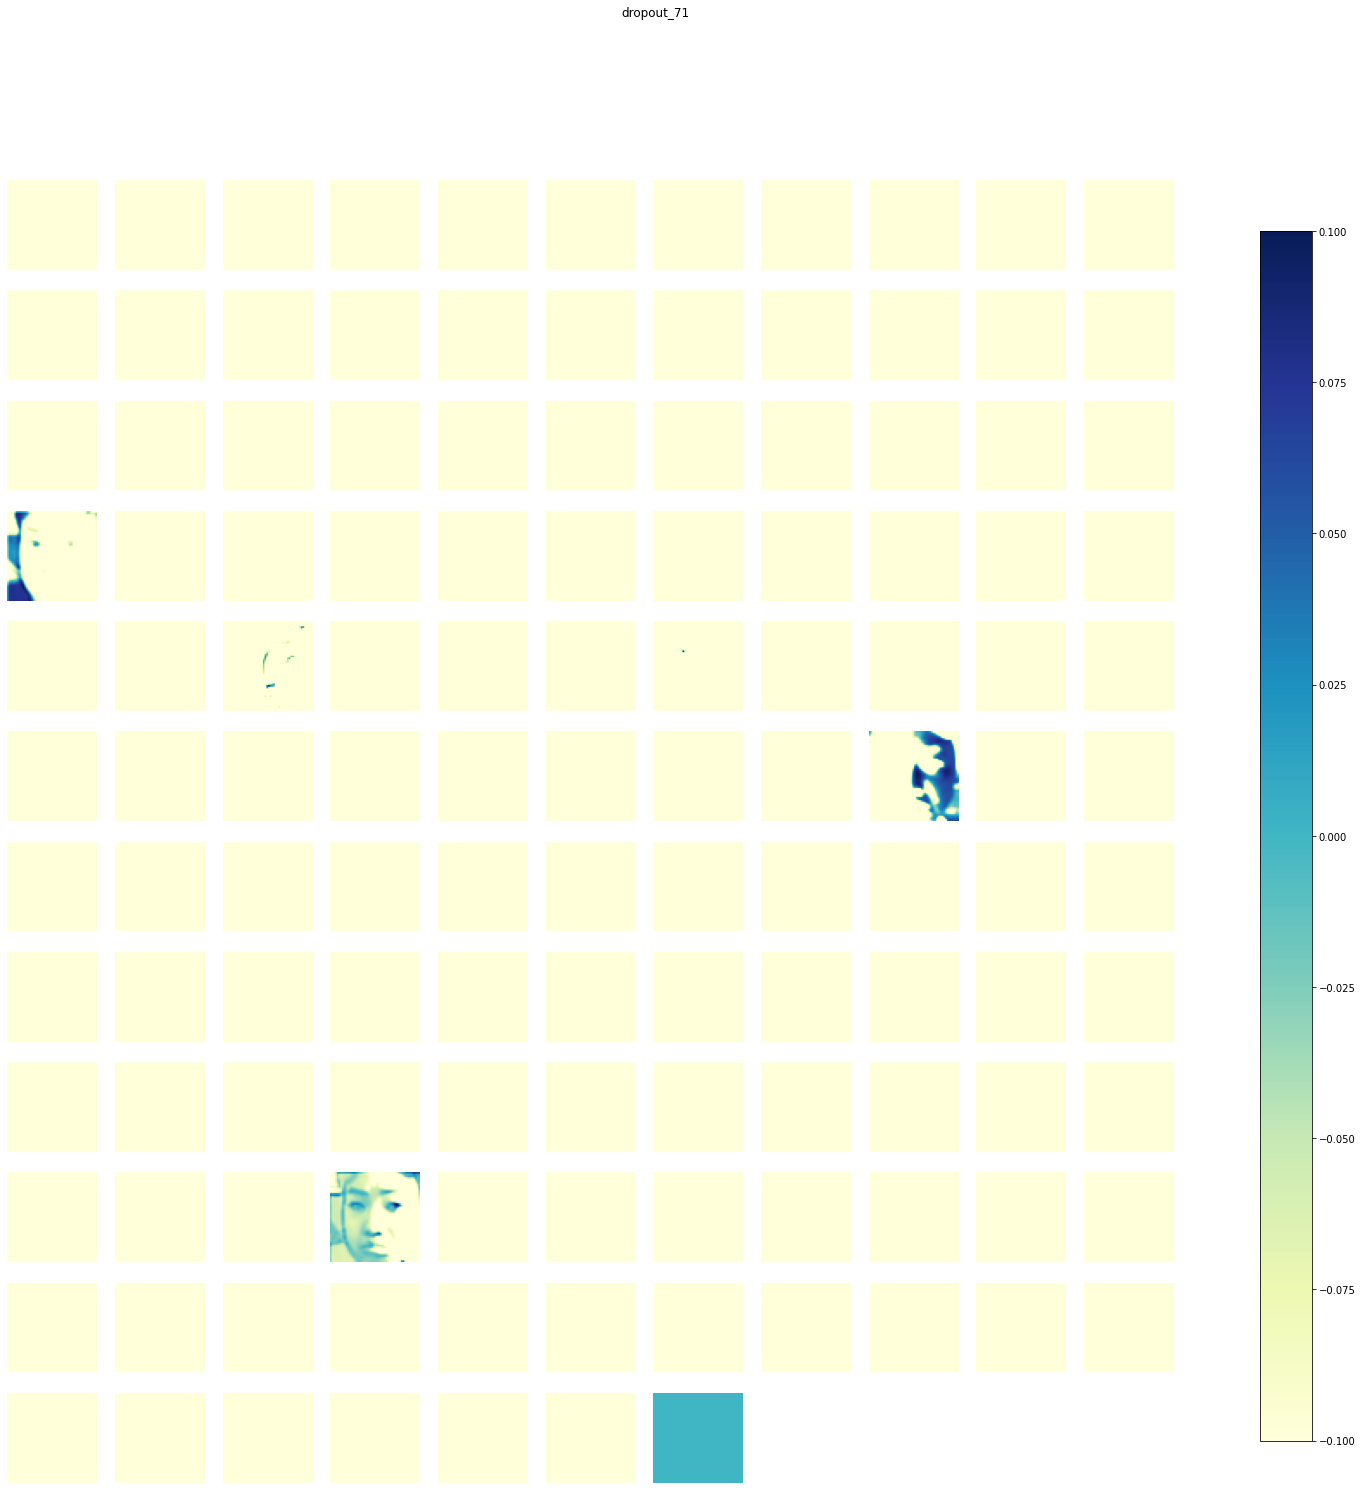

flatten_34 (1, 346112) 


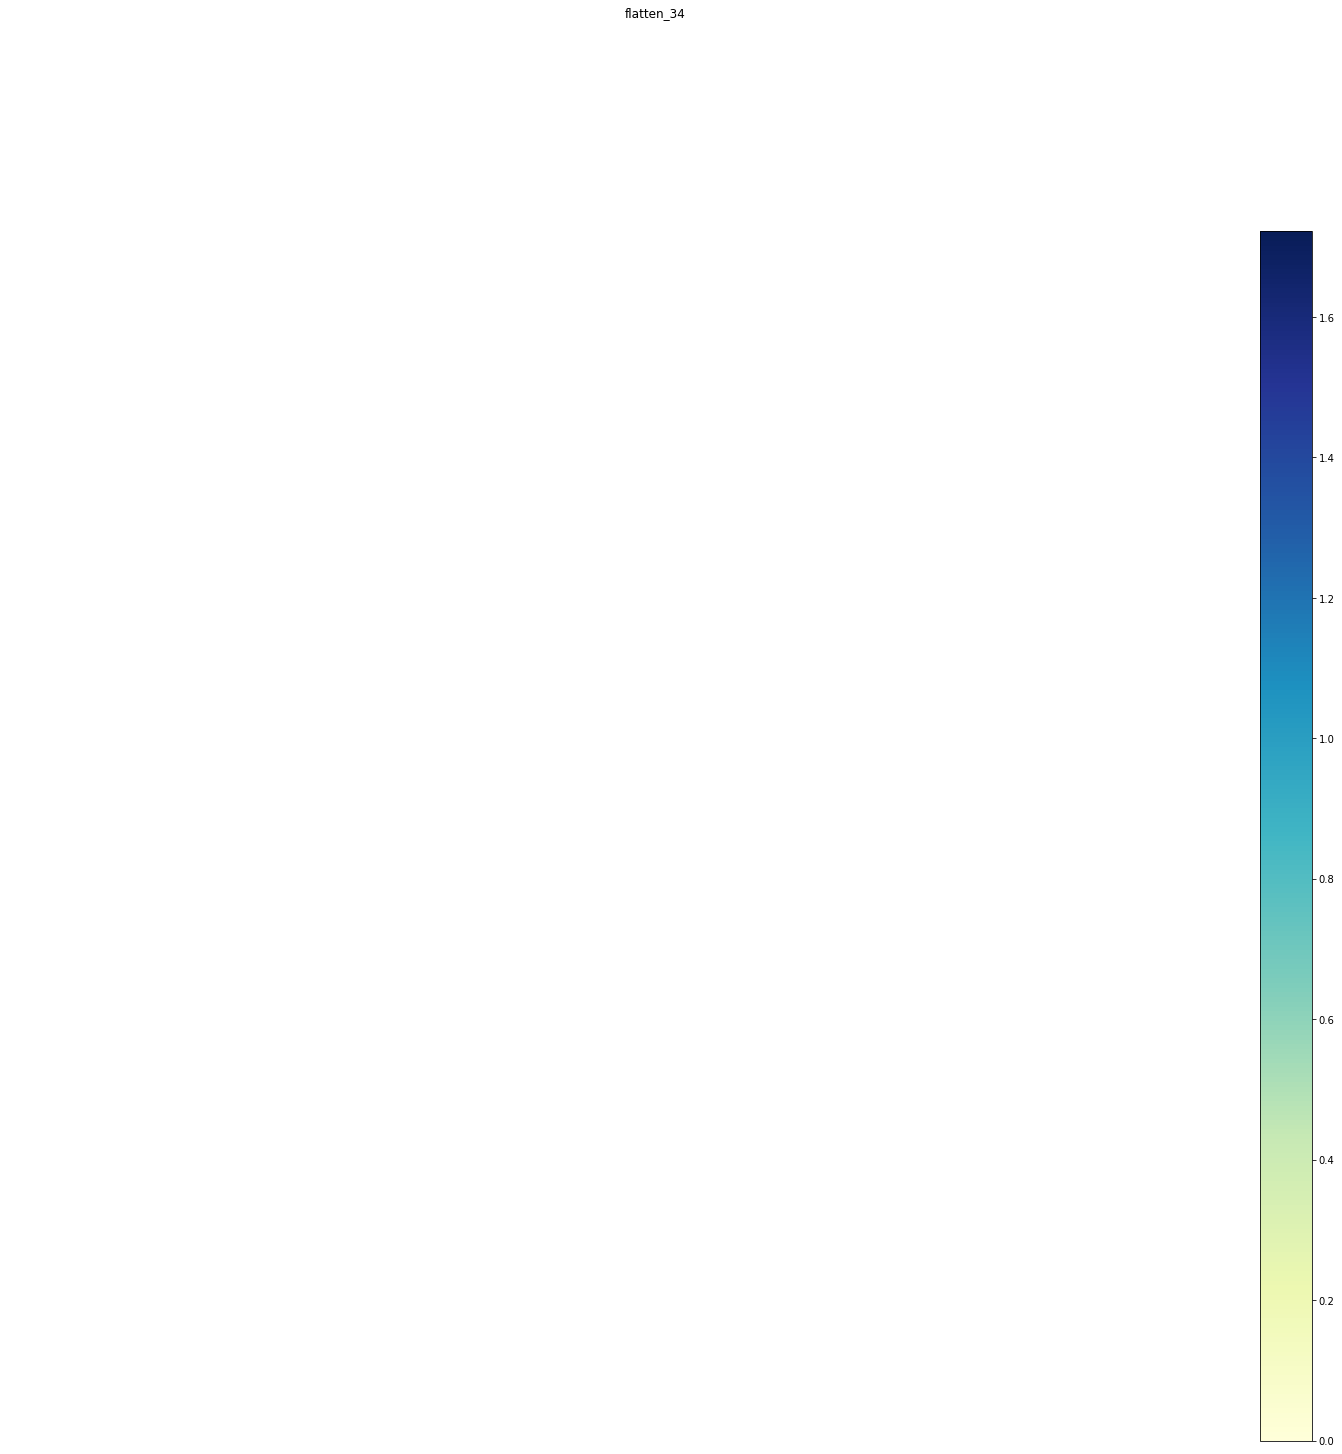

dense_68 (1, 128) 


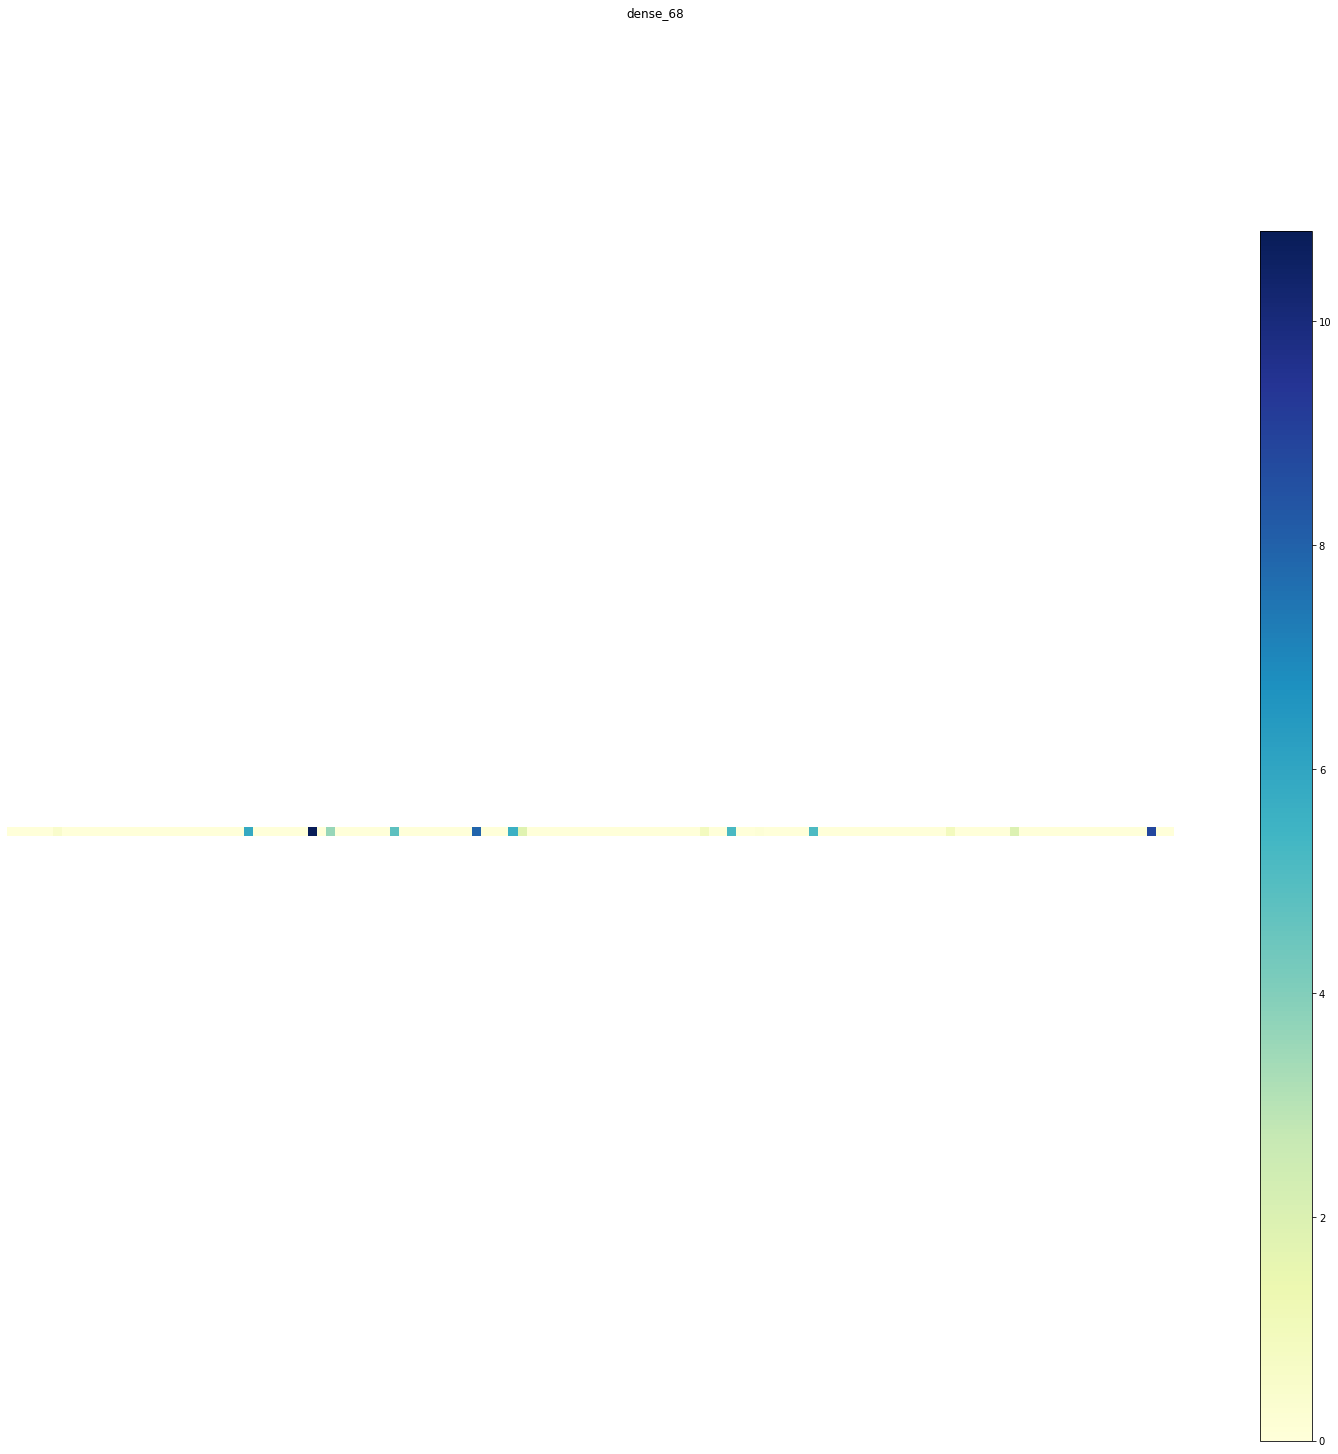

dropout_72 (1, 128) 


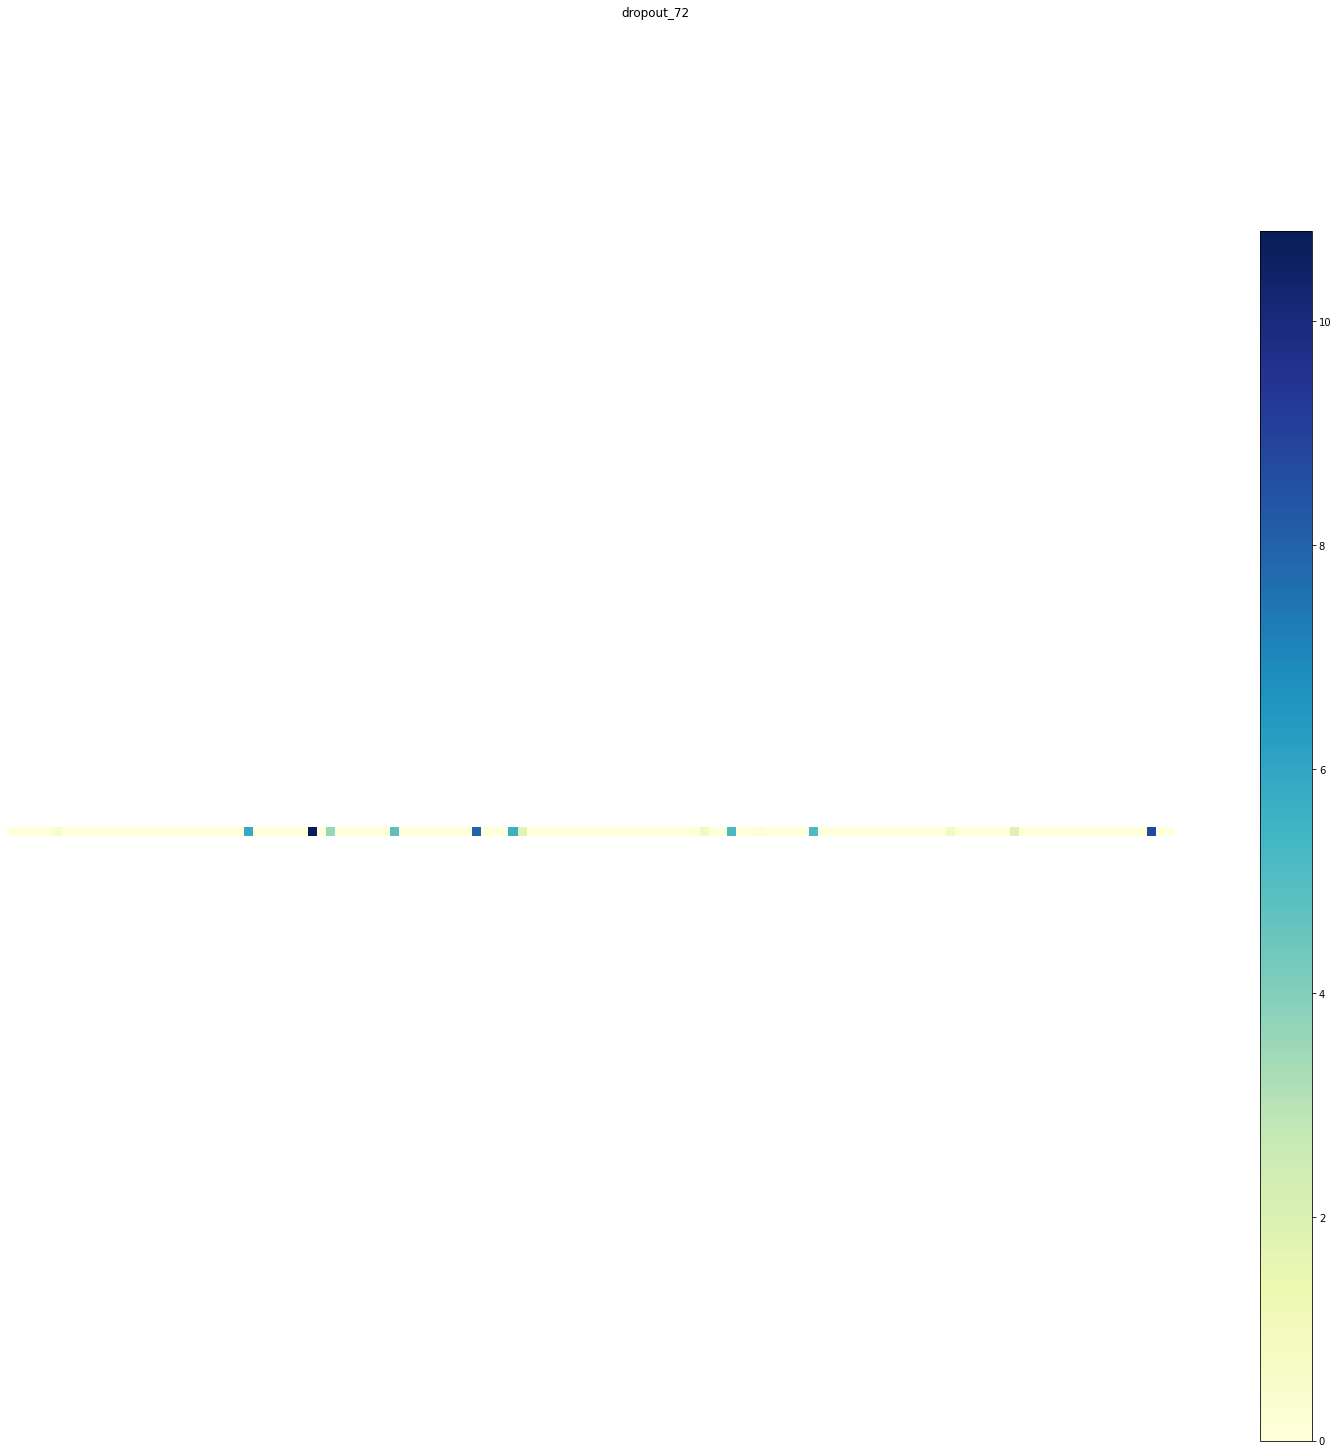

dense_69 (1, 4) 


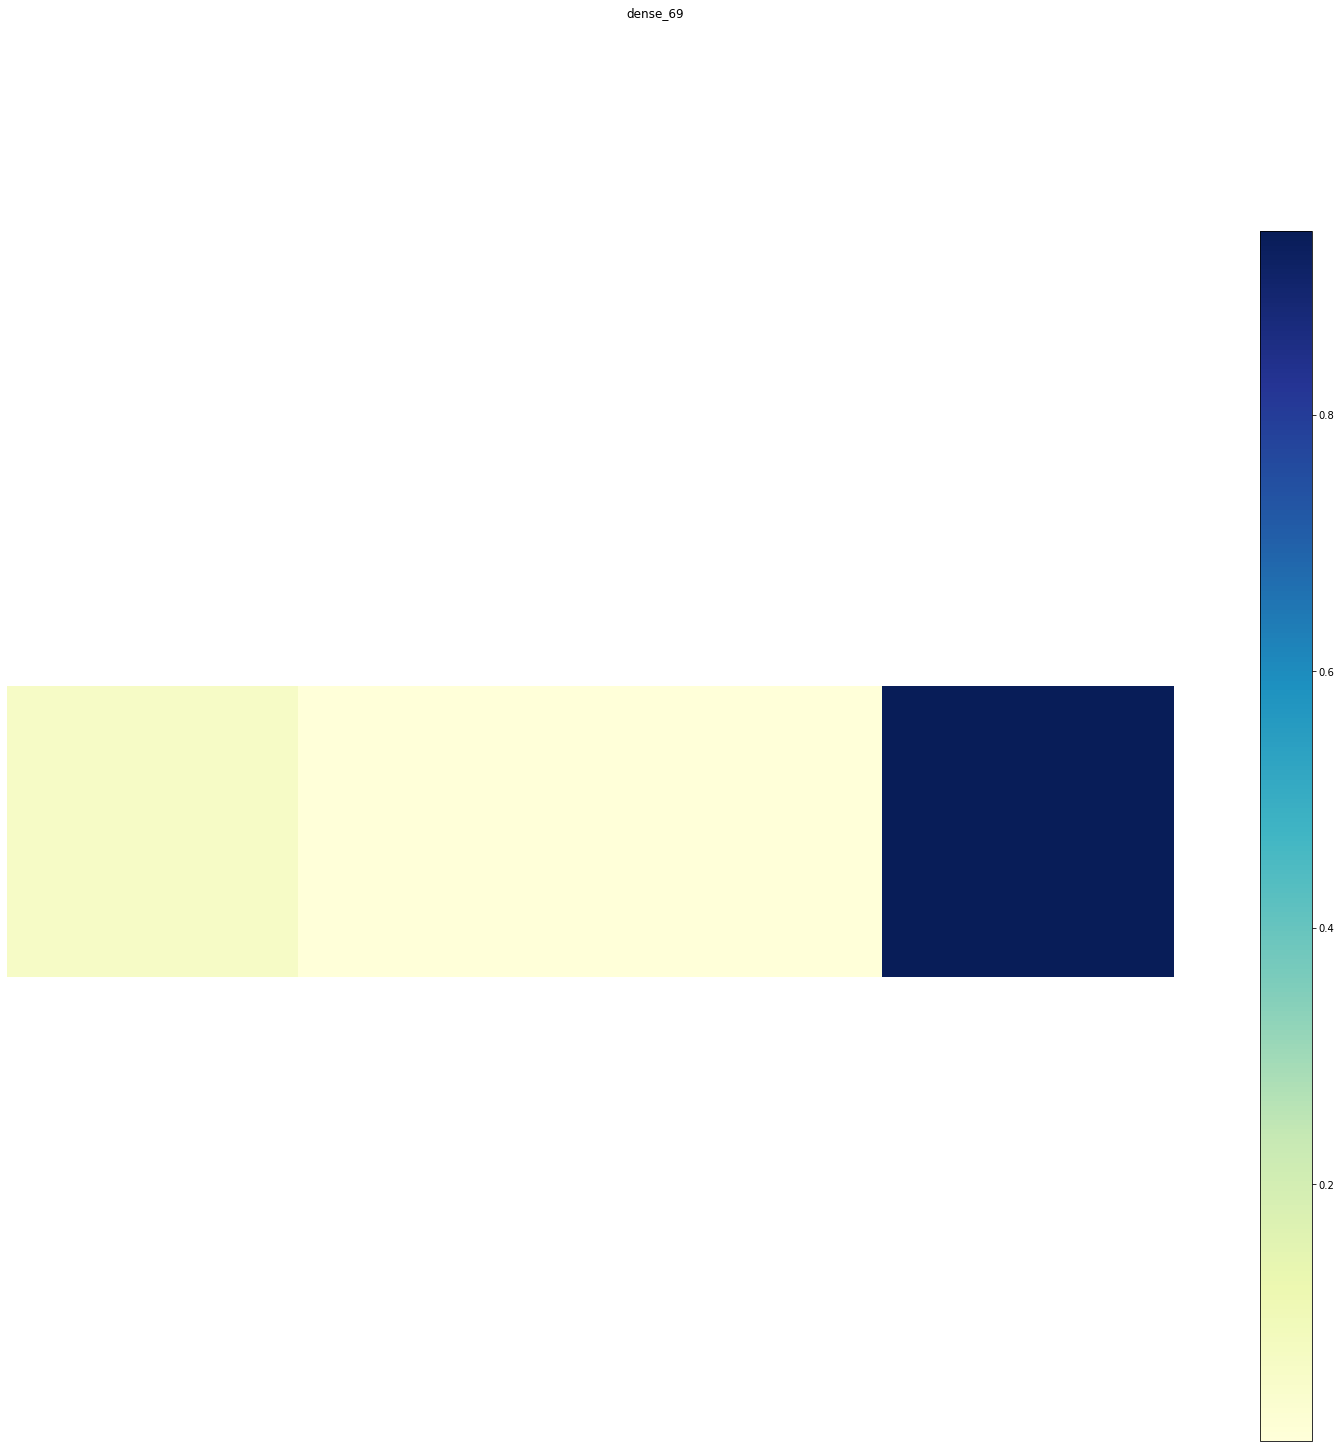

In [282]:
keract_inputs = X_test[2:3]
keract_targets = y_test[:1]
activations = get_activations(cnn3, keract_inputs)
display_activations(activations=activations,cmap='YlGnBu')